cpu
0.1 2.5
0.0 2.0
-10.0 -1.0
2.0 73.0
1.0 500.0
4.0 12.0
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e-01 | test_loss: 1.23e+00 | reg: 7.46e+01 | : 100%|█| 200/200 [00:21<00:00,  9.17


saving model version 0.1
MAE: 0.8014
MSE: 1.5252
MAPE: 3.1343
R²: 0.9963
RMSE: 1.2350
fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,0,4) with log10, r2=0.9800545573234558, c=1
fixing (0,0,5) with log10, r2=0.9921344518661499, c=1
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,1,1) with log10, r2=0.9617723226547241, c=1
fixing (0,1,2) with 0, r2=0.0, c=0
fixing (0,1,3) with 0, r2=0.0, c=0
fixing (0,1,4) with 0, r2=0.0, c=0
fixing (0,1,5) with 0, r2=0.0, c=0
fixing (0,2,0) with 0, r2=0.0, c=0
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,2,2) with 0, r2=0.0, c=0
fixing (0,2,3) with 0, r2=0.0, c=0
fixing (0,2,4) with 0, r2=0.0, c=0
fixing (0,2,5) with log10, r2=0.9780200123786926, c=1
fixing (0,3,0) with 0, r2=0.0, c=0
fixing (0,3,1) with log10, r2=0.9781333804130554, c=1
fixing (0,3,2) with 0, r2=0.0, c=0
fixing (0,3,3) with 0, r2=0.0, c=0
fixing (0,3,4) with 0, r2=0.0, c=0
fixing (0,3,5)

148.739*log10(3.23*x_1 + 4.228) + 28.372*log10(4.926*x_3 + 4.734) + 6.606*log10(2.597*x_4 + 0.004) + 32.385*log10(5.325*x_6 + 8.29) - 81.261*log10(8.497*log10(9.327 - 4.864*x_1) - 2.616) - 72.509

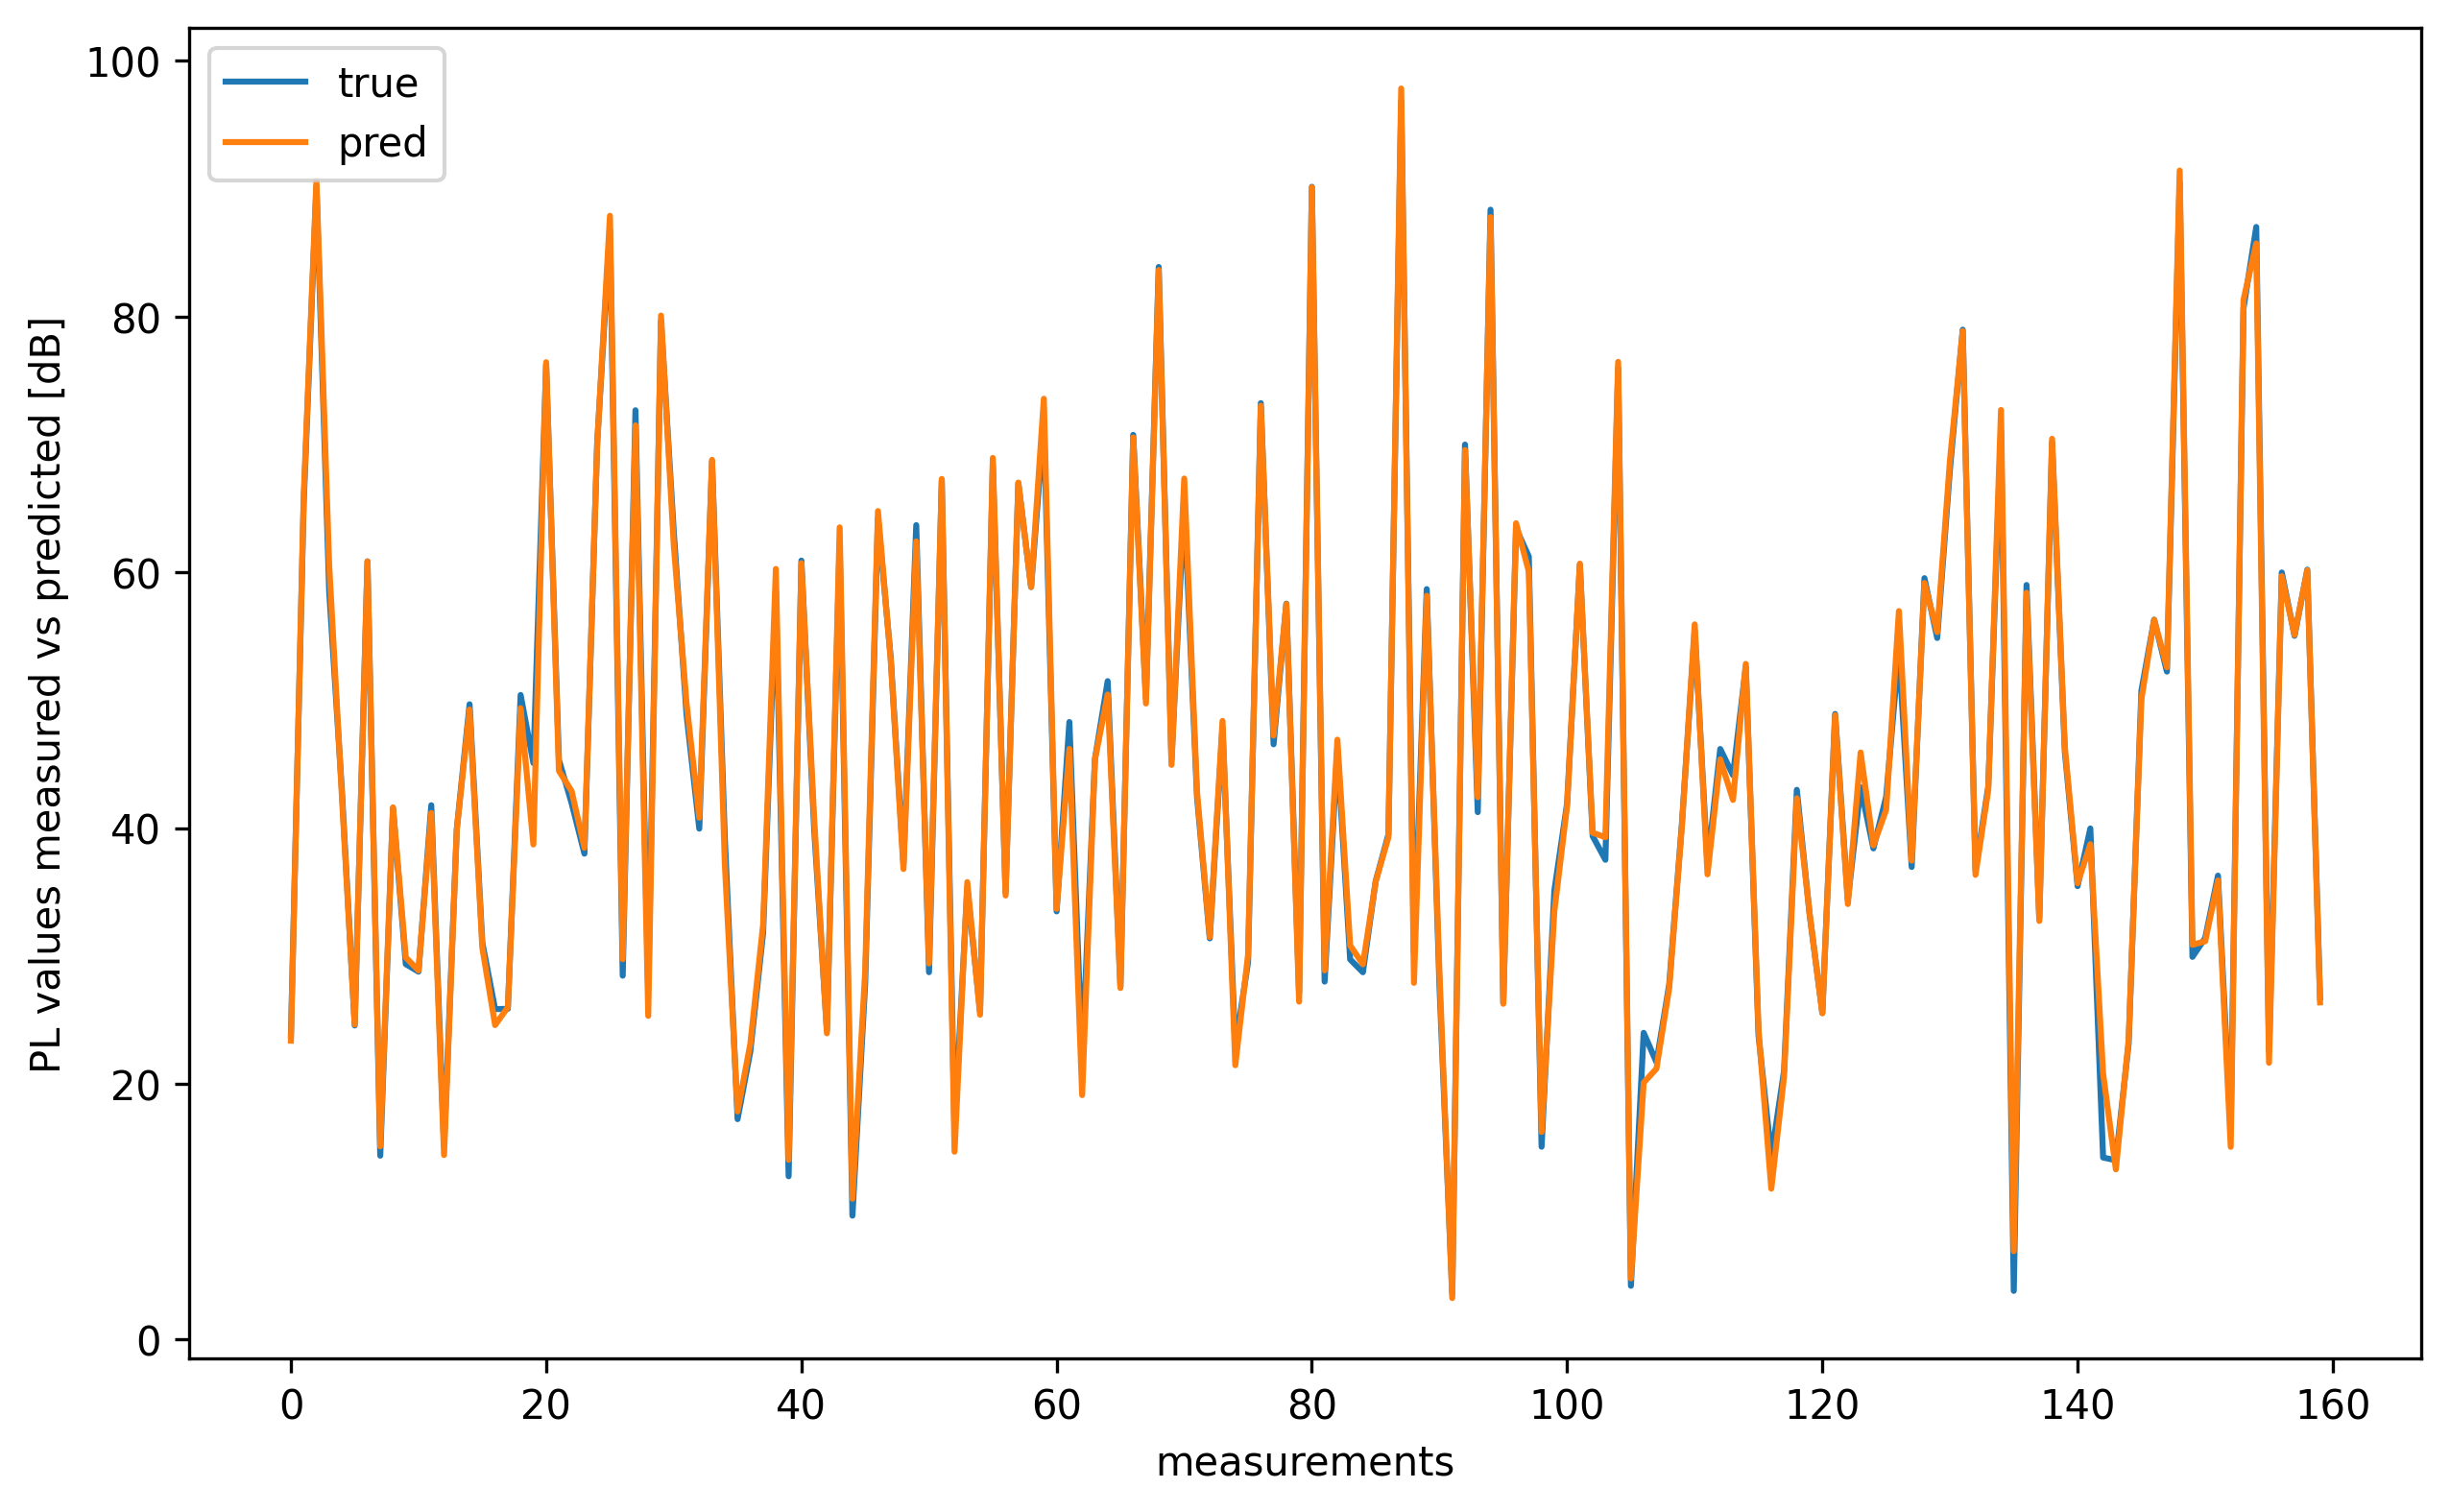

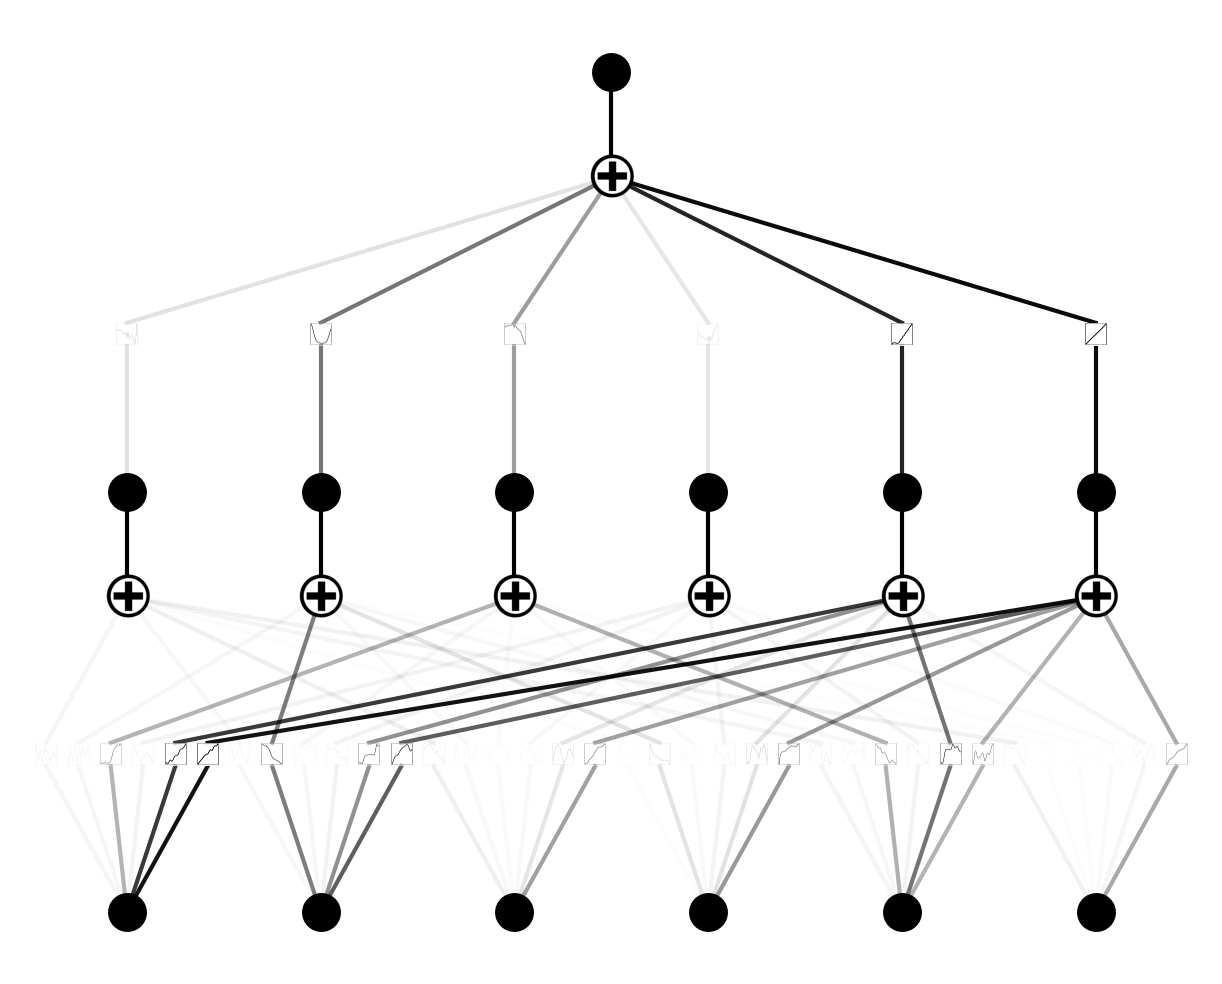

In [49]:

from kan import *
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()[:250]
    y_pred = y_pred.detach().cpu().numpy().ravel()[:250]
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])[:250]
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label=metric_name)
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


import re  # for extracting intervals

# Read the data from the Excel file
abg_data = pd.read_excel('Propagation_models.xlsx', sheet_name='ABG', header=0)

# First row contains normalization factors, let's store it
first_row = abg_data.iloc[0]

# Drop the first row after using it for normalization
abg_data = abg_data.drop(index=0)

# Clean column names by stripping whitespace
abg_data.columns = abg_data.columns.str.strip()

# Function to extract the interval from string or list (like "[x,y]" or [x, y])
def extract_interval(interval_value):
    # Ensure interval_value is a string, in case it's a sympy.Basic or other object
    interval_str = str(interval_value)
    
    if isinstance(interval_str, str):
        # Using regex to extract the values between the square brackets
        match = re.match(r'\[([0-9.-]+),\s*([0-9.-]+)\]', interval_str)
        if match:
            return float(match.group(1)), float(match.group(2))  # Return as a tuple (min, max)
        else:
            raise ValueError(f"Invalid interval format: {interval_str}")
    elif isinstance(interval_value, list) and len(interval_value) == 2:
        # Directly return the two values in the list as min and max
        return float(interval_value[0]), float(interval_value[1])
    else:
        raise ValueError(f"Invalid interval format: {interval_value}")

# Normalize the columns based on the first row
for col in ['alpha', 'gamma', 'beta', 'f', 'd', 'X']:
    # Extract the min and max values from the first row, whether it's a string or a list
    min_val, max_val = extract_interval(first_row[col])
    print(min_val, max_val)
    # Normalize the data using the extracted min and max
    abg_data[col] = (abg_data[col] - min_val) / (max_val - min_val)

# Convert specified columns to floats
for col in ['alpha', 'gamma', 'beta', 'f', 'd', 'X']:
    abg_data[col] = pd.to_numeric(abg_data[col], errors='coerce').astype(float)

# Check for any NaN values after conversion
if abg_data.isnull().any().any():
    print("Warning: NaN values detected in the dataset.")

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = abg_data[['alpha', 'gamma', 'beta', 'f', 'd', 'X']].values  # Input features (f, d, X, n)
labels = abg_data['PL_ABG'].values    # Output labels (PL_ABG)

# Split into 80% train + 20% test
train_val_input, test_input, train_val_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Split the remaining 80% into 80% train + 20% validation
train_input, val_input, train_label, val_label = train_test_split(
    train_val_input, train_val_label, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
val_input = torch.tensor(val_input, dtype=torch.float32)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
val_label = torch.tensor(val_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {
    'train_input': train_input,
    'test_input': val_input,
    'train_label': train_label,
    'test_label': val_label
}

# Develop the KAN model using a generic approach where the first 
# layers equal the number of inputs and the last the number of outputs
model = KAN(width=[6,6,1], grid=10, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt='LBFGS', steps=200, lamb=0.0001);

eval_kan(model, nan, dataset)
model.plot()

# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)

MAE: 1.7440
MSE: 5.5328
MAPE: 5.2863
R²: 0.9868
RMSE: 2.3522


-0.03*x_1 + 0.05*x_2 - 0.71*x_4 - 0.05*x_5 + 0.15*x_6 + 55.6*(-0.06*x_2 - 0.e-2*x_3 - sqrt(0.3*x_1 + 1) - 0.04*sqrt(x_4 + 0.65) - 0.02*sqrt(0.43*x_5 - 1) - 0.08)**2 + 12.68*cos(-0.21*x_1 + 0.51*x_2 + 0.03*x_4 + 2.68) - 74.33

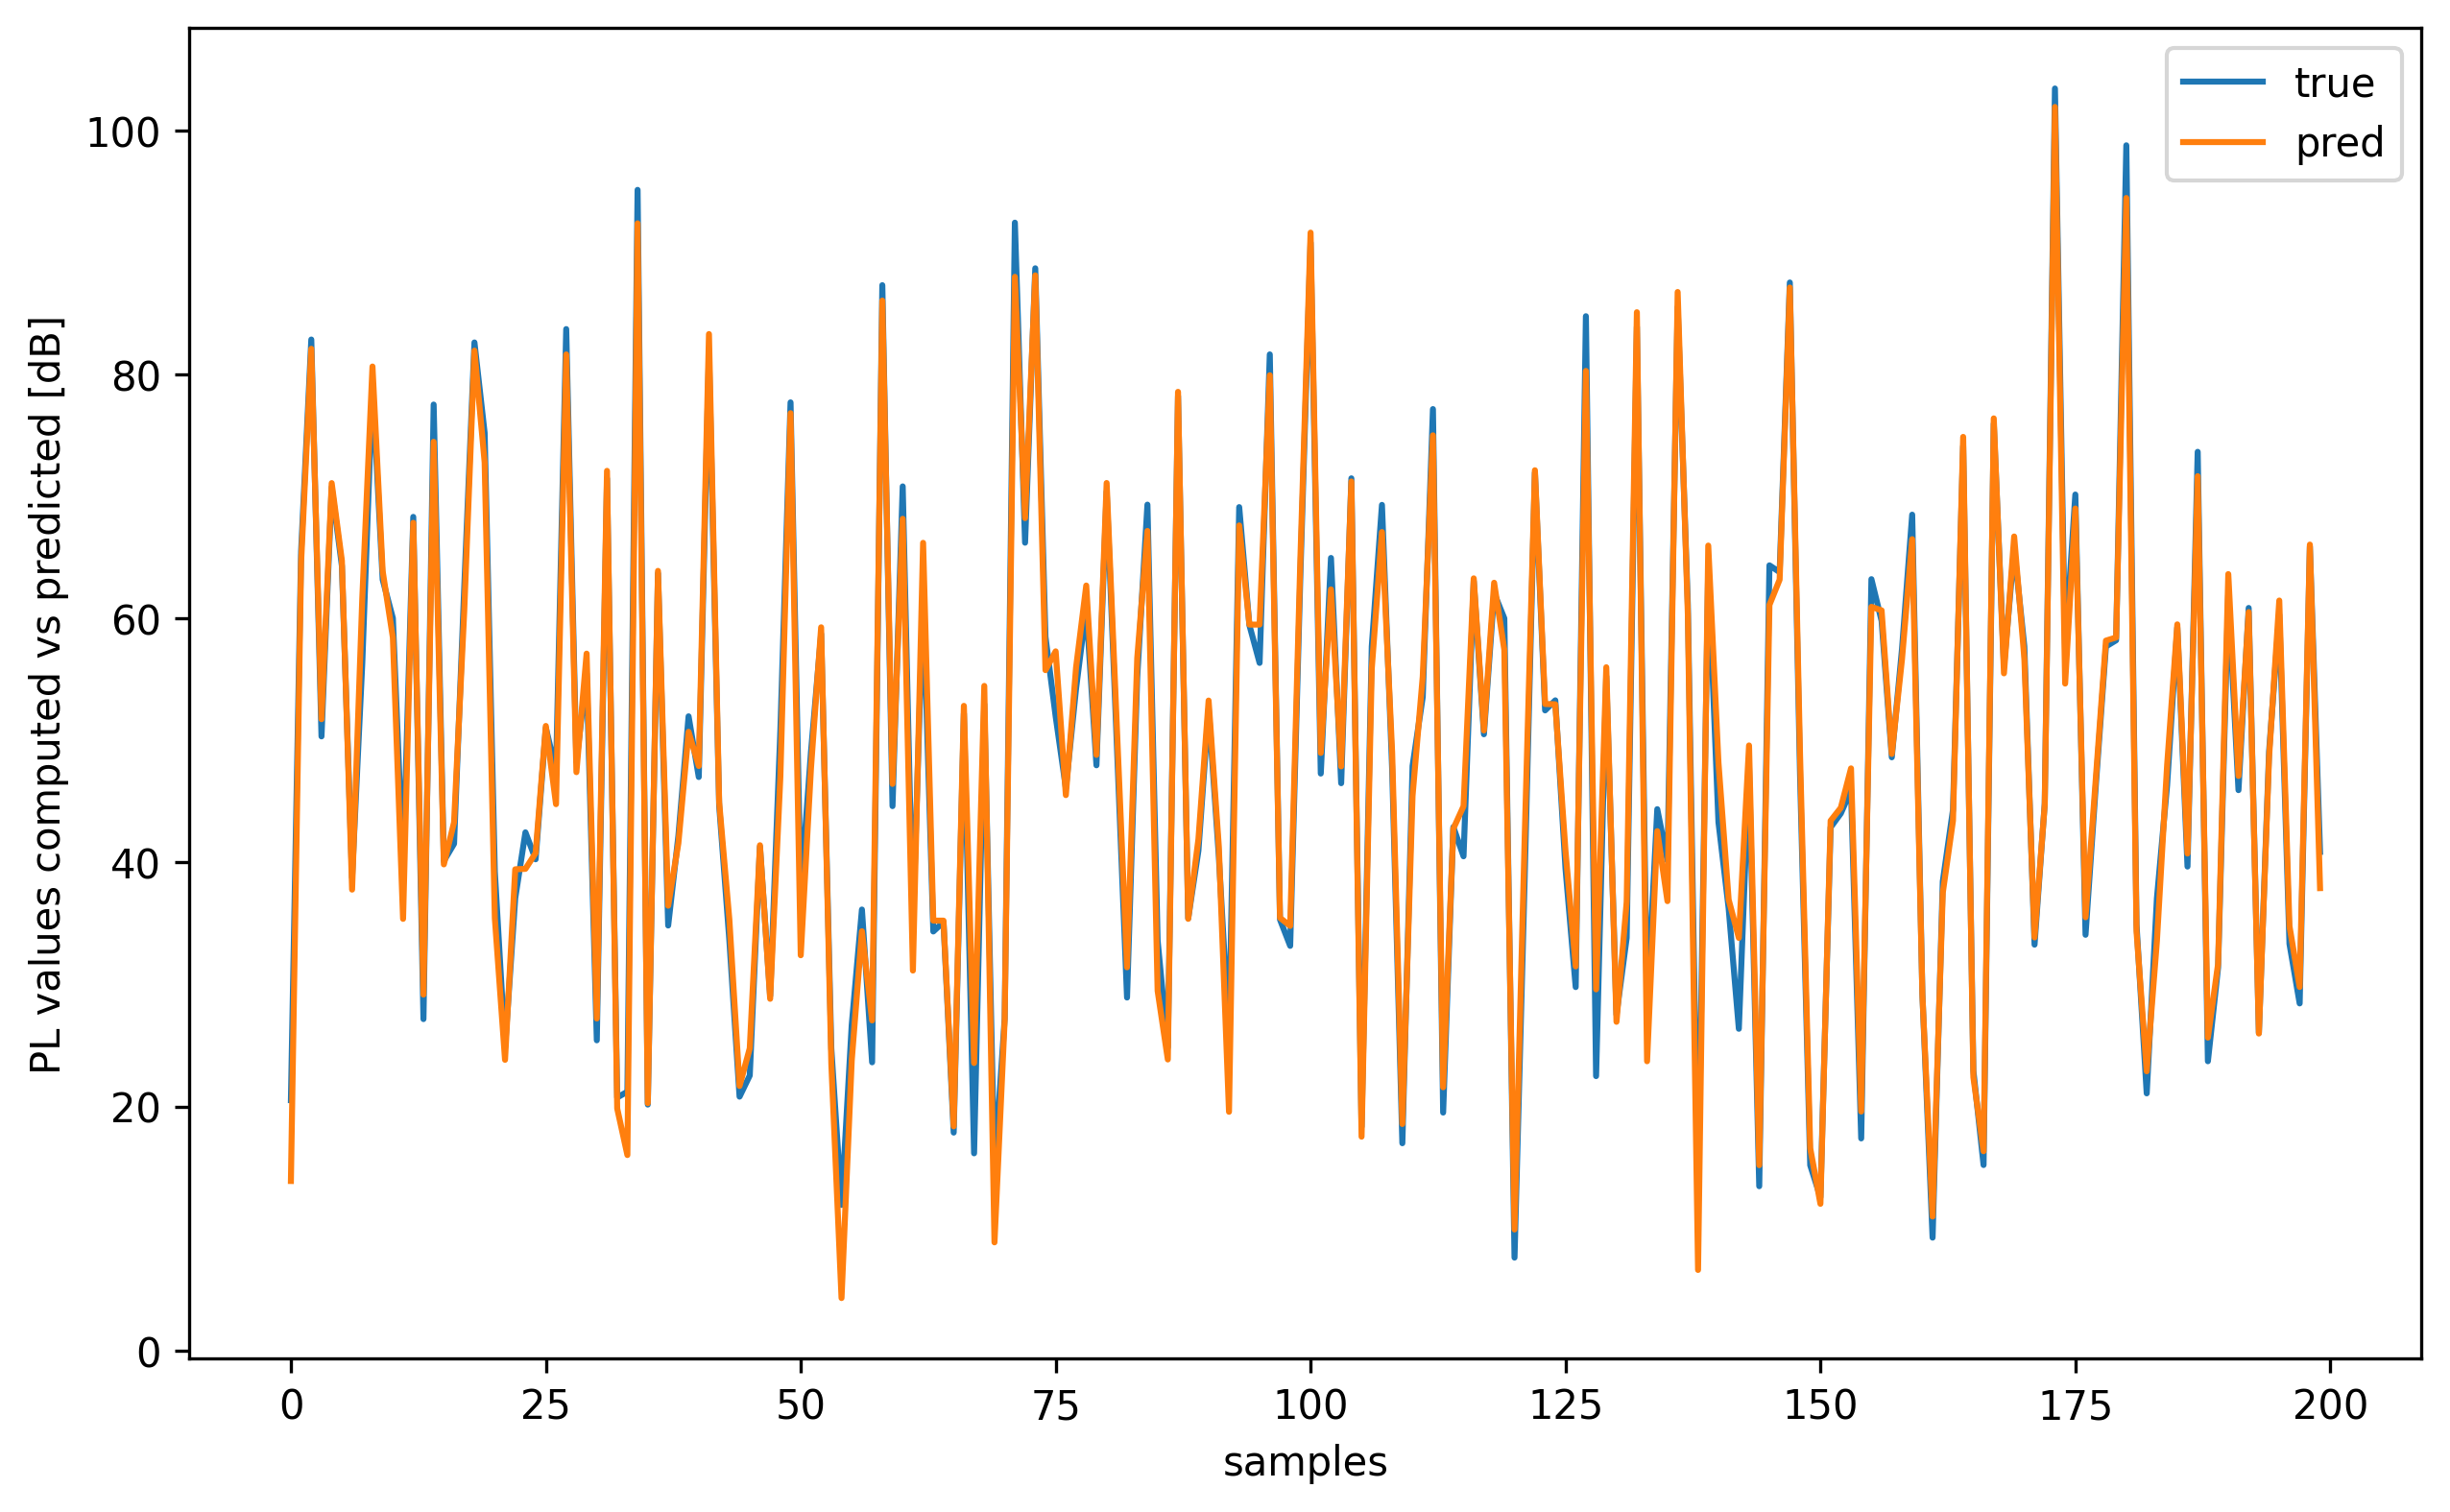

In [43]:

# we re-train the KAN architecture with the explainable symbolic approximation as the weights on thee edges 
# change compared to the model with splines 
model.fit(dataset, opt="LBFGS", steps=300, lamb=0.02);

eval_kan(model, dataset)

#print the symbolic formula
ex_round(model.symbolic_formula()[0][0], 2)


In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([50, 100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002, 0.000002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[6,6,1],
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s])

            if not np.isnan(results['train_loss']).any():
                train_losses += results['train_loss']
                test_losses += results['test_loss']

                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)


checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.02


| train_loss: 3.92e-01 | test_loss: 5.88e-01 | reg: 9.93e+01 | : 100%|█| 50/50 [00:05<00:00,  8.79it

saving model version 0.1


TypeError: eval_kan() missing 1 required positional argument: 'test_data'

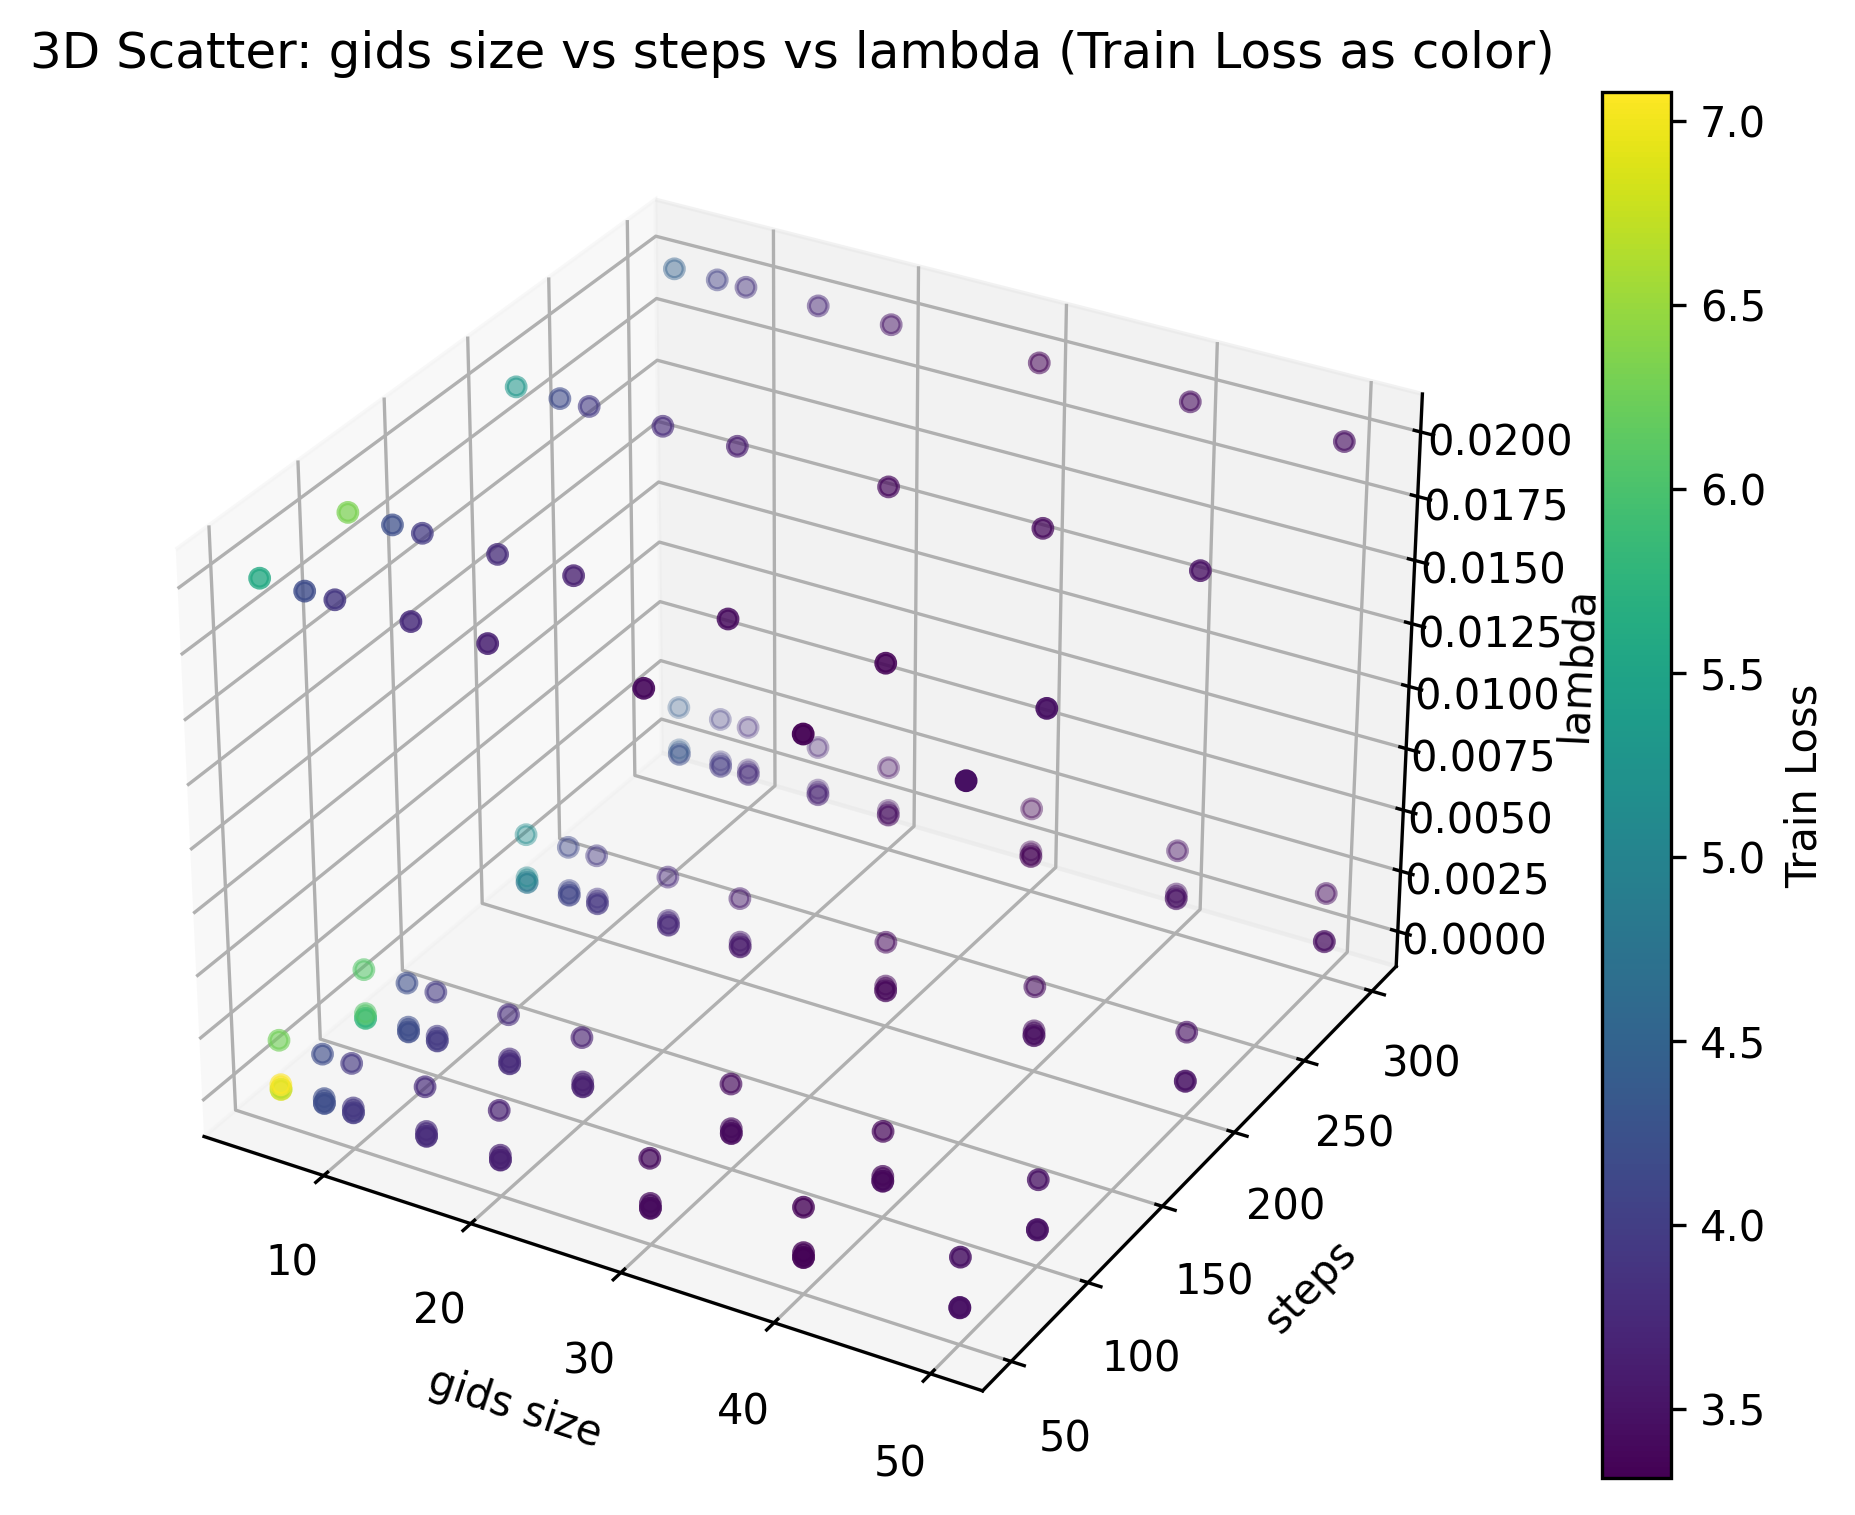

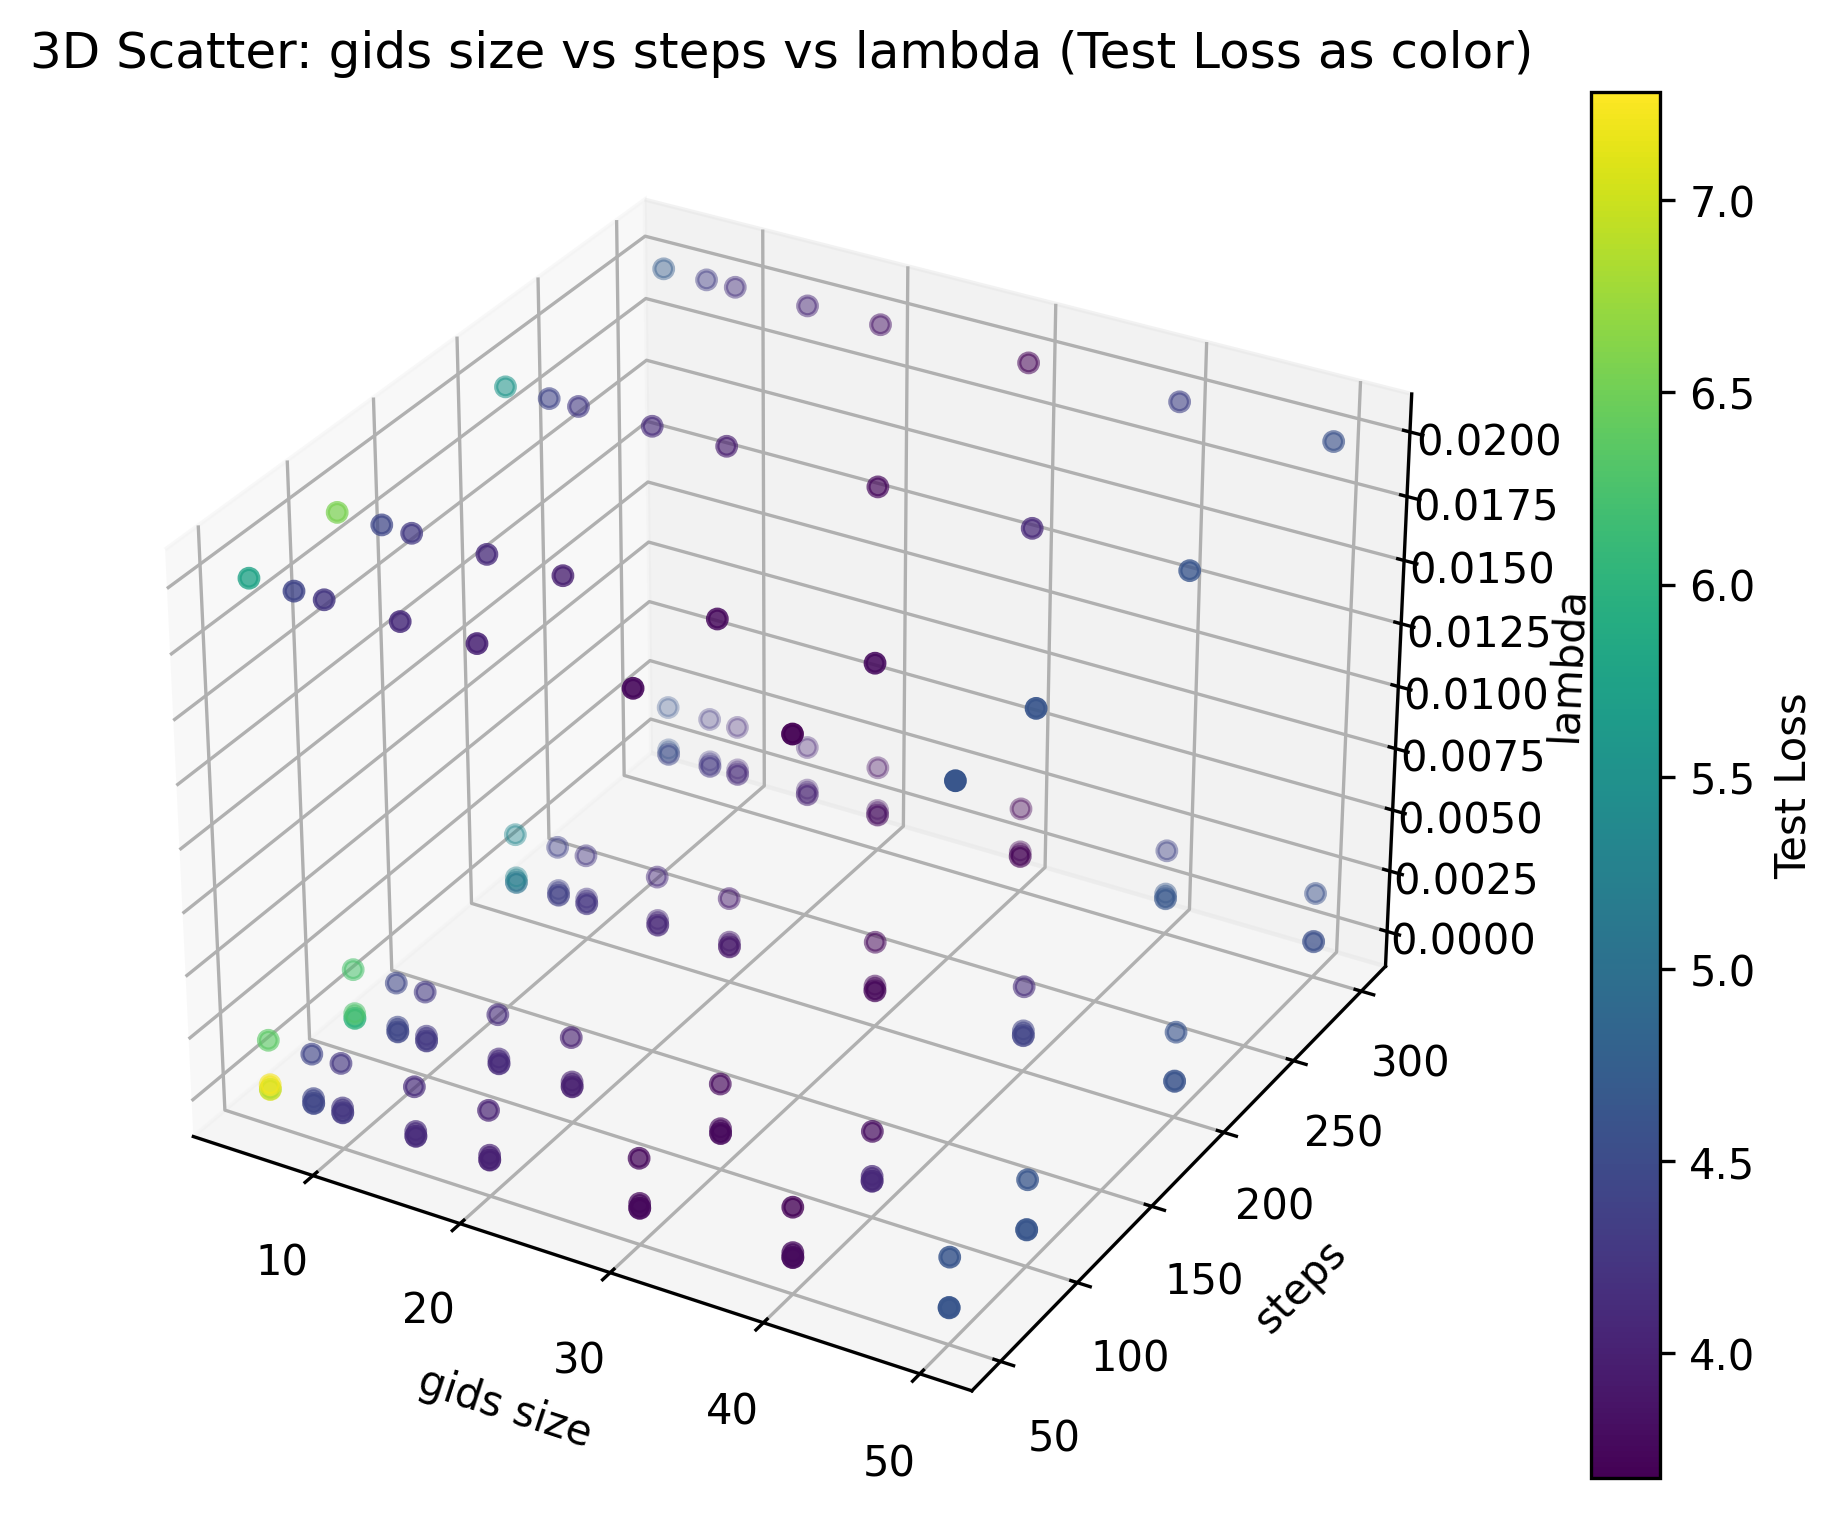

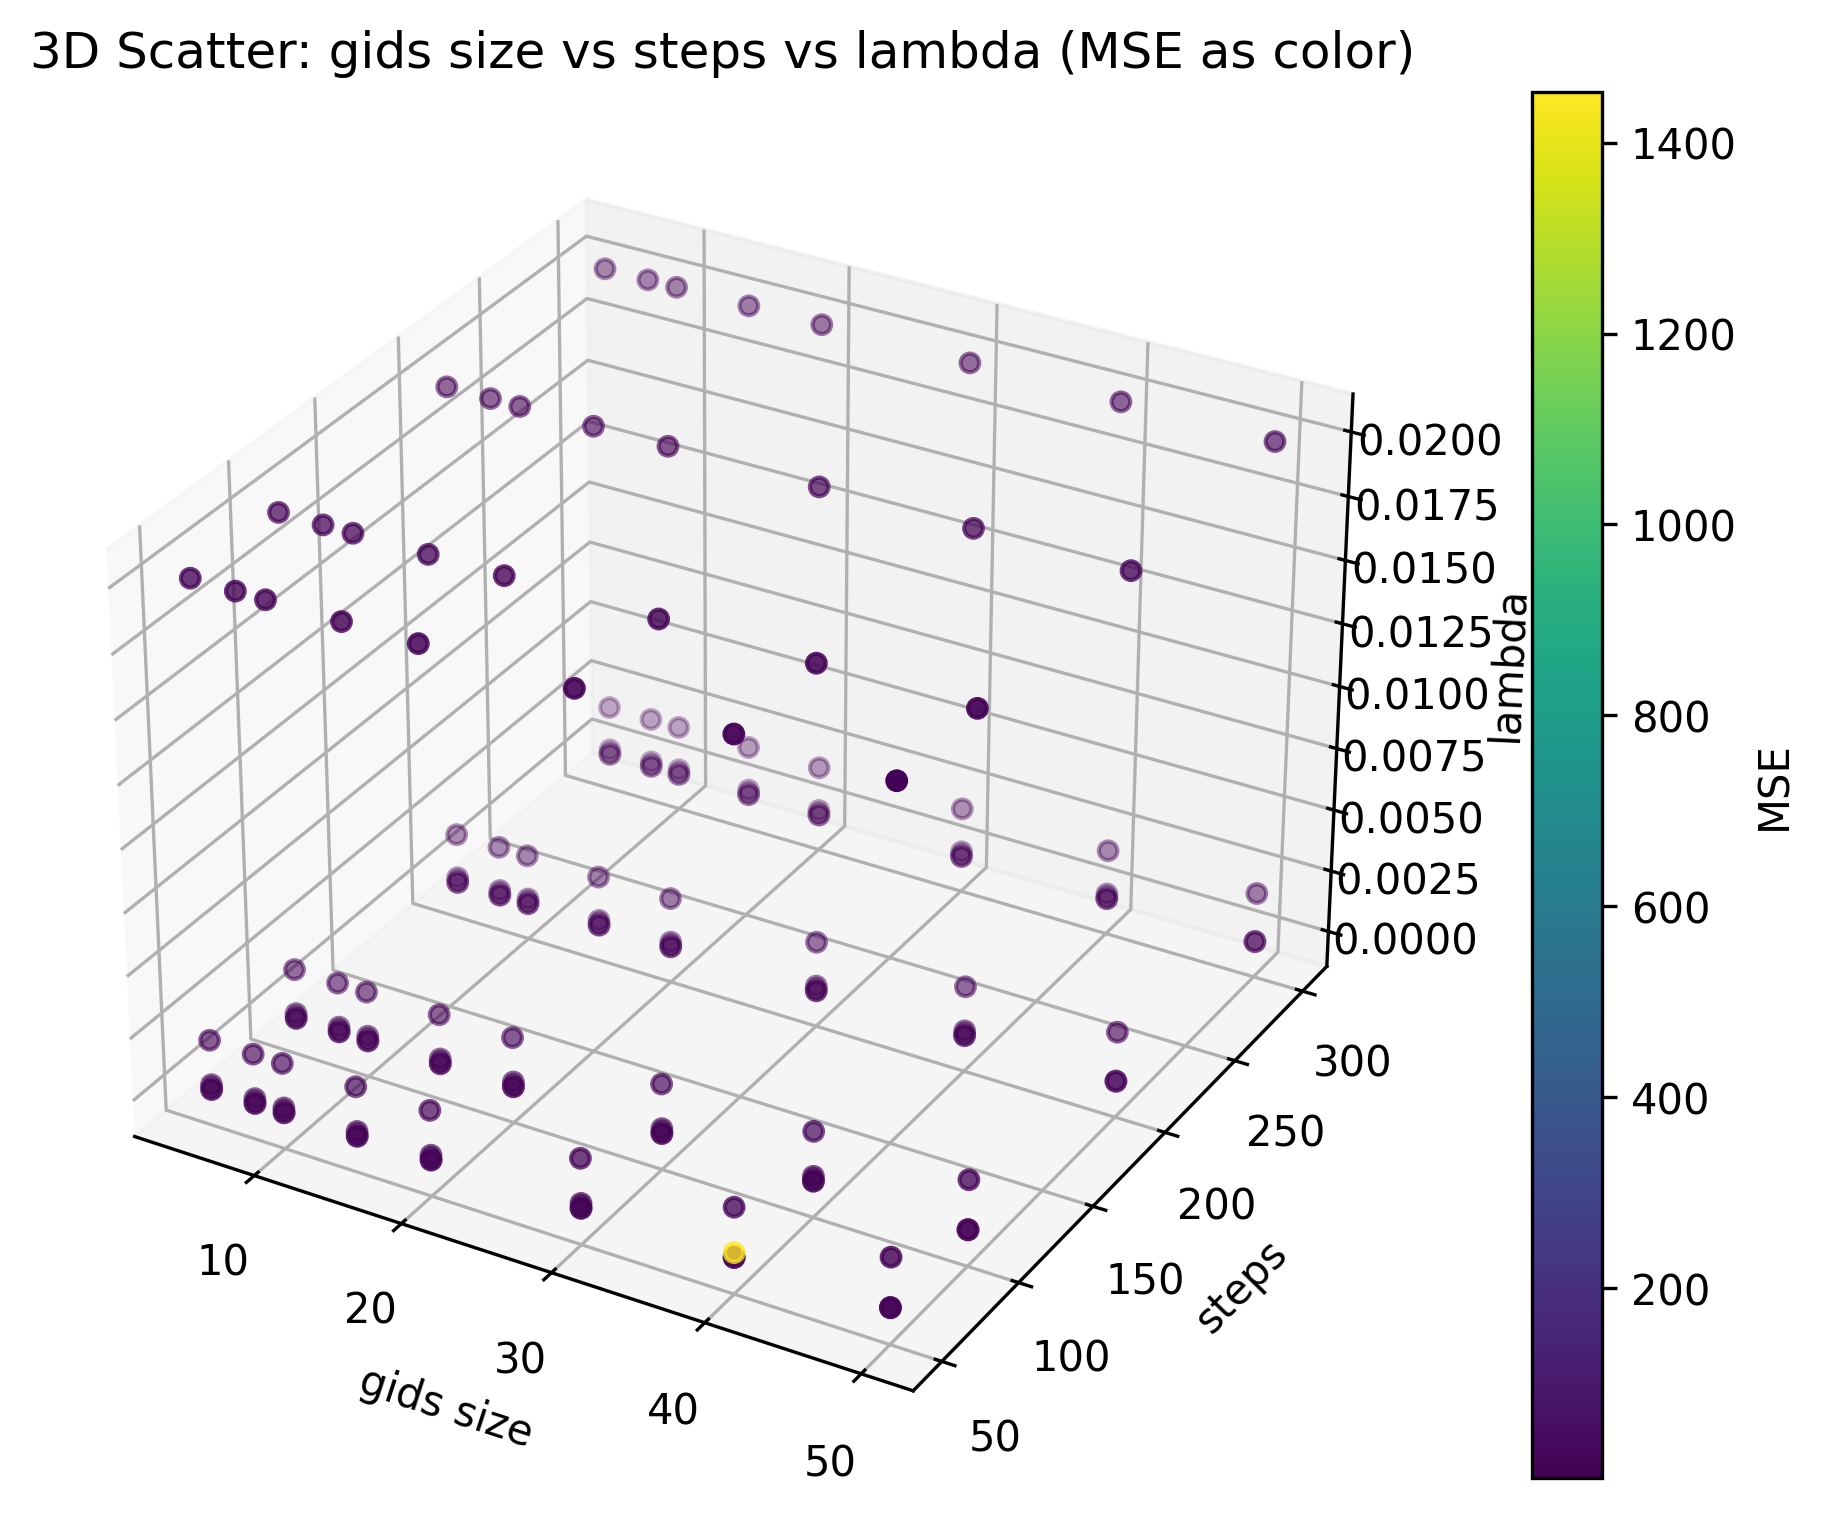

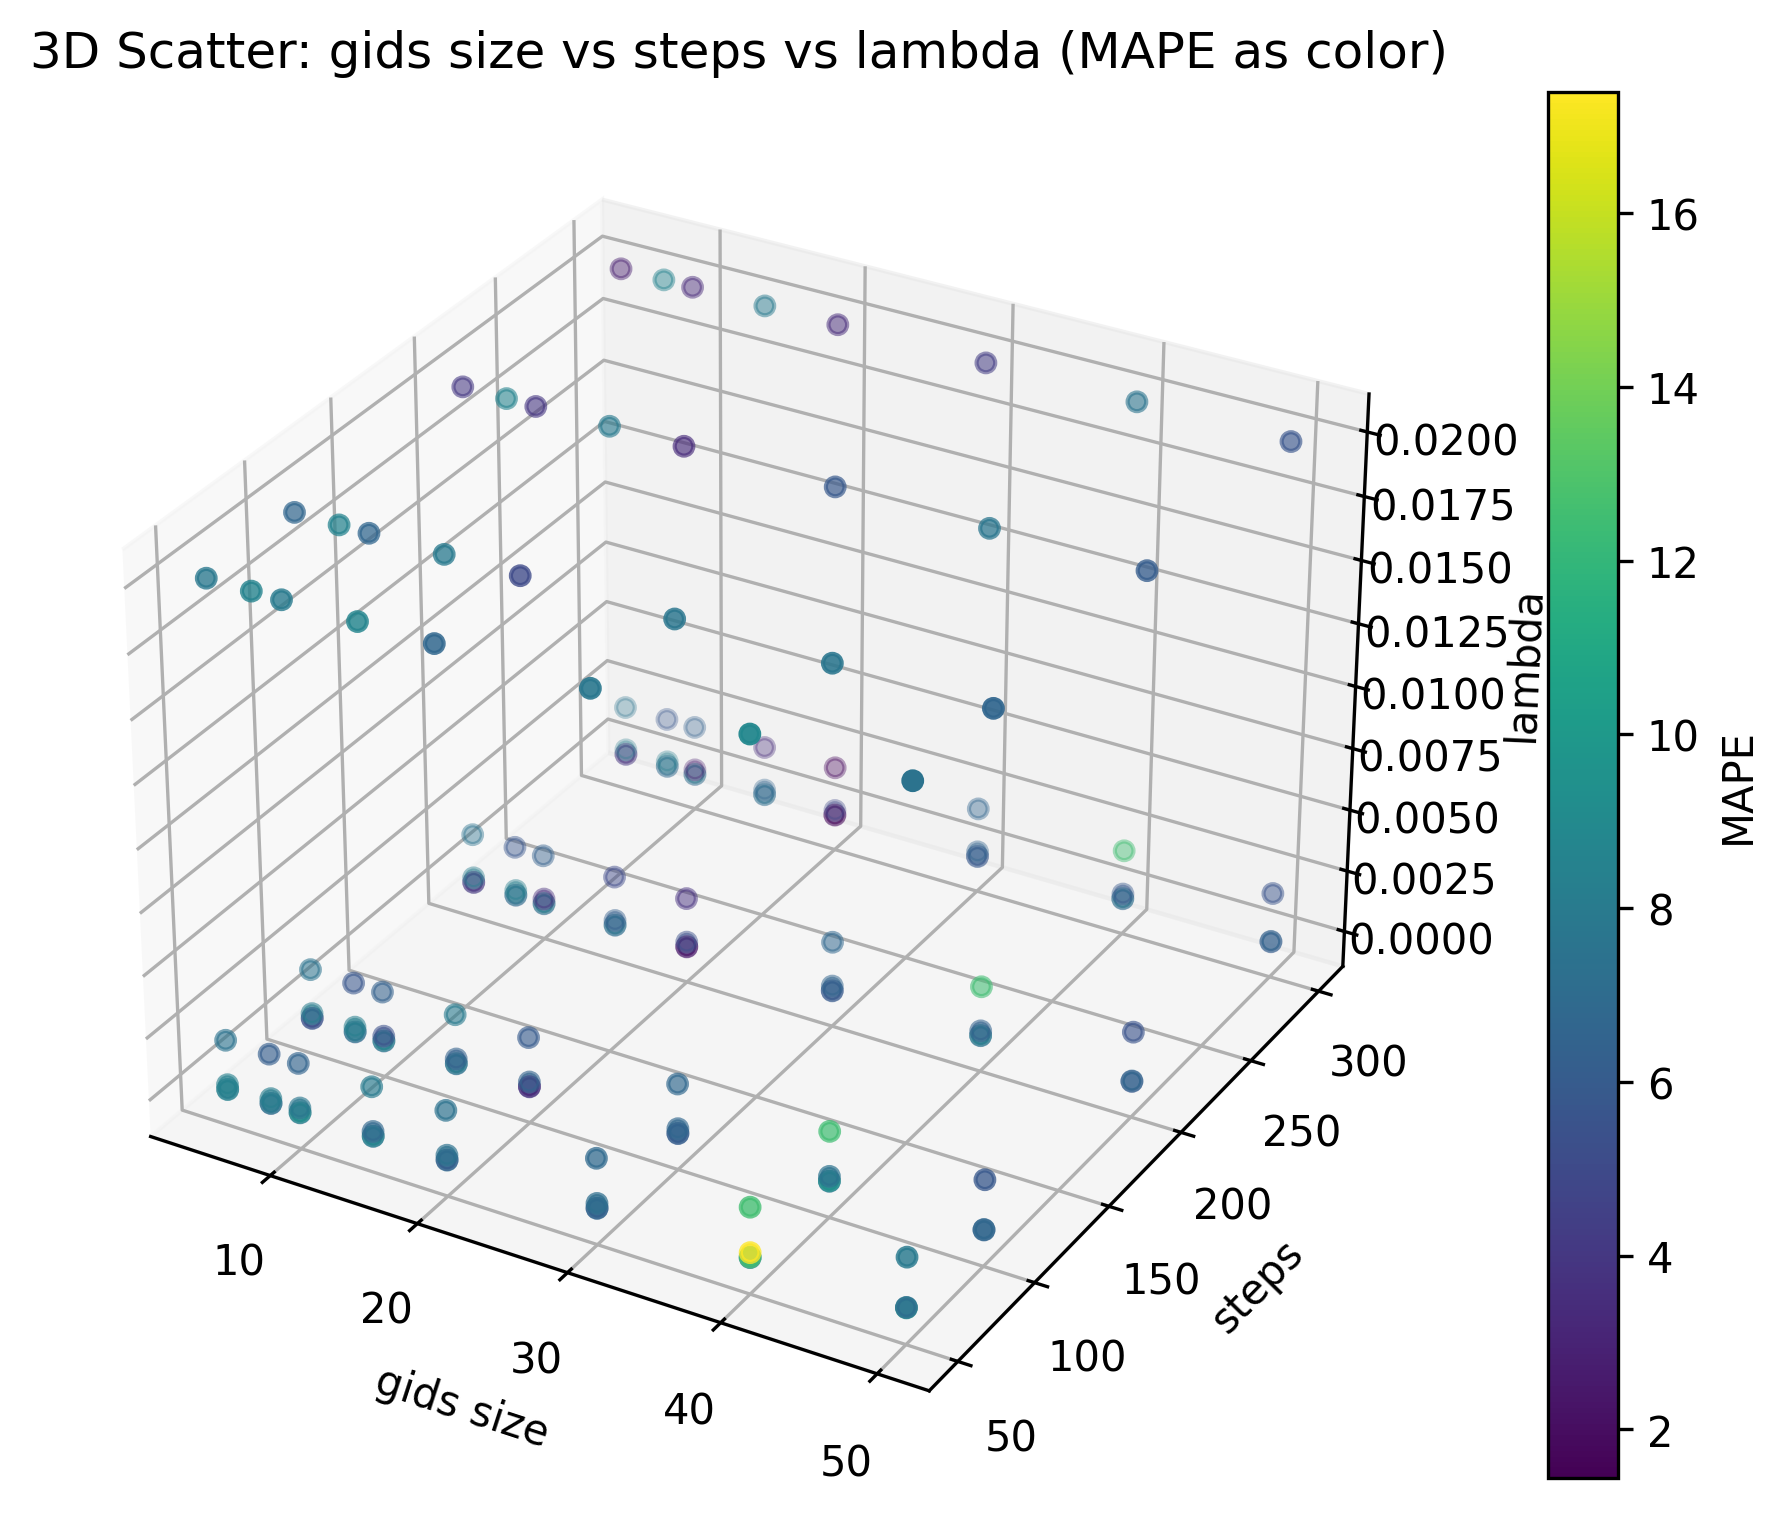

In [15]:
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_losses, "Train Loss")
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, te_losses, 'Test Loss')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_maes, 'MAE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mses, 'MSE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mapes, 'MAPE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_r2s, 'R2')

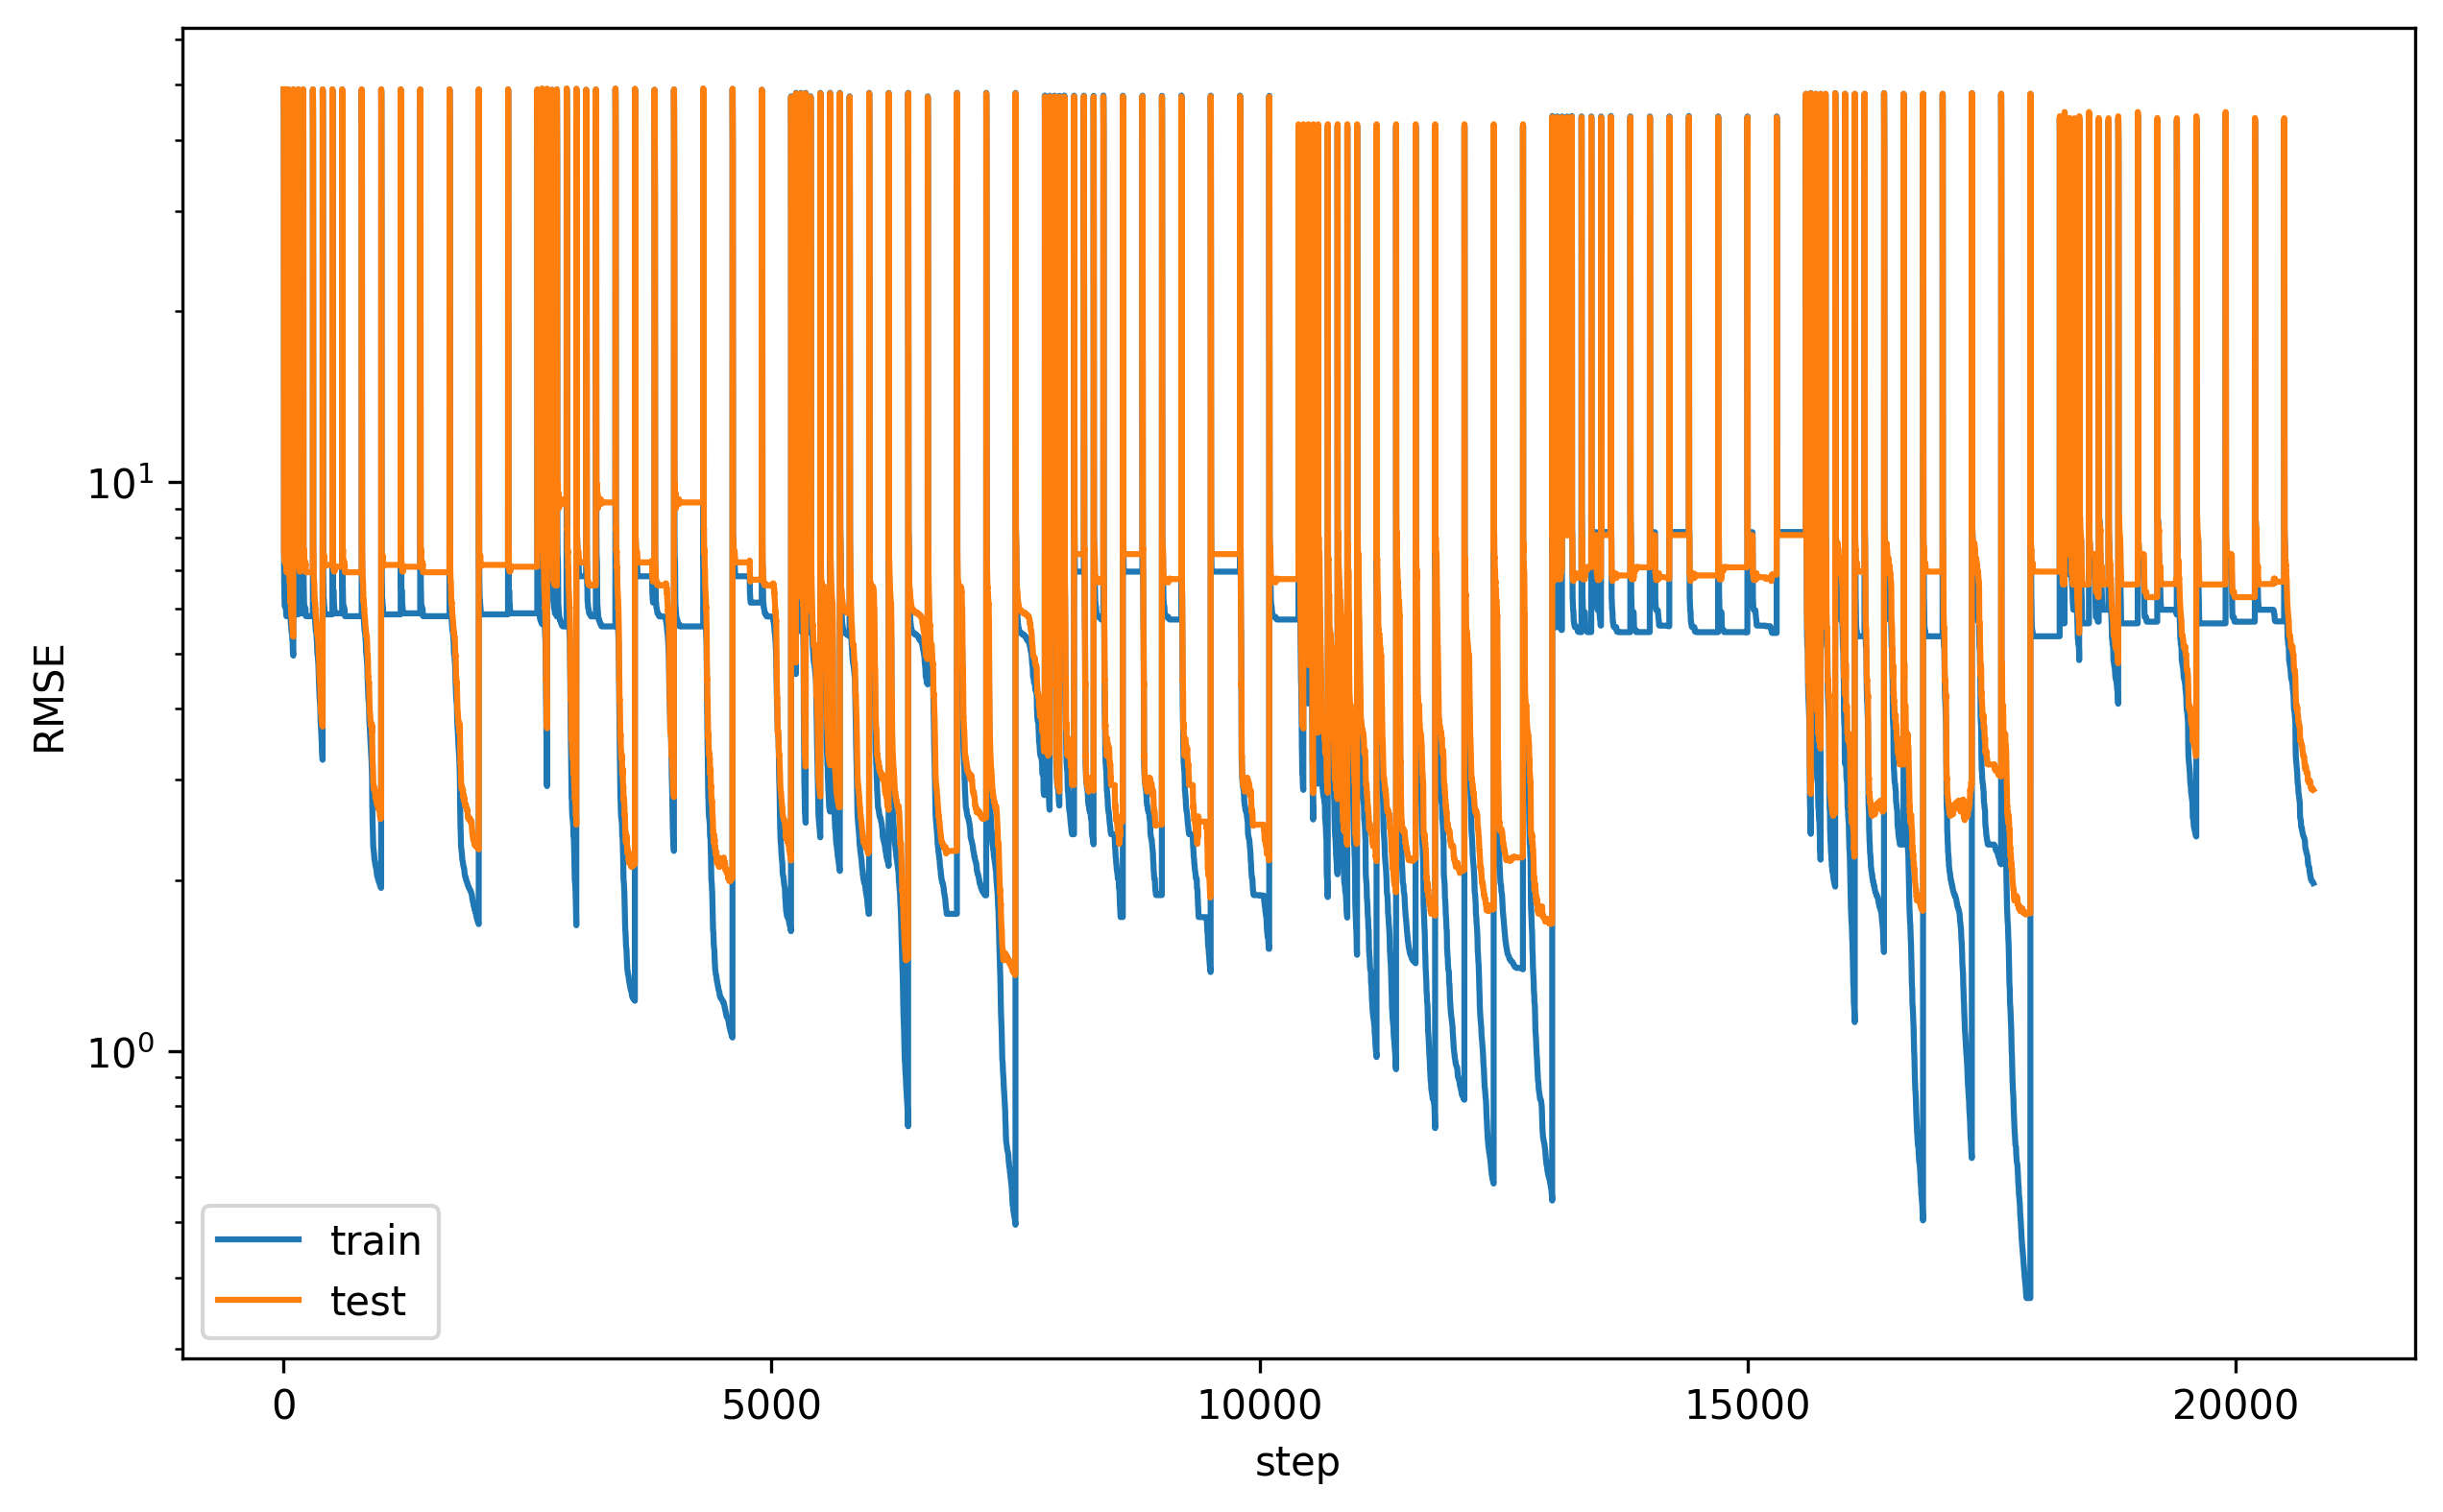

In [ ]:
# Plot the training and test losses.
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')